# Capstone Project: Divya Kamath; Group 6; AAI 520 Natural Lanugage Processing and Gen AI
# Step-by-Step: Agentic Investment Research System
The Agentic AI flows is as follows: 

**Planner → Researcher → Preprocessing → Router → (YahooFinance | News | Earnings) → Evaluator → (Memory & Output) → Publisher**


## Step 0 — Imports & Optional API Keys

In [ ]:
import os, re, time, json, math, logging
from typing import Any, Dict, List, Optional, Tuple
import numpy as np
import pandas as pd
import requests as _rqs
import matplotlib.pyplot as plt
import os
import datetime as dt
import pprint as pp
from pathlib import Path


# Optional: set keys here or via environment before running
from dotenv import load_dotenv
load_dotenv(dotenv_path = r"C:\Users\DeeHa\.env")

NEWSAPI_KEY = os.getenv("NEWSAPI_KEY")
FRED_API_KEY = os.getenv("FRED_API_KEY")
SEC_CONTACT = os.getenv("SEC_CONTACT")

logging.basicConfig(level=logging.INFO, format="[%(levelname)s] %(message)s")
print("NEWSAPI_KEY present:", bool(os.getenv("NEWSAPI_KEY")))
print("FRED_API_KEY present:", bool(os.getenv("FRED_API_KEY")))
print("SEC_CONTACT present:", bool(os.getenv("SEC_CONTACT")))
print("Imports ready. Keys optional; stubs will run without them.")

NEWSAPI_KEY present: True
FRED_API_KEY present: True
SEC_CONTACT present: True
Imports ready. Keys optional; stubs will run without them.


## Step 1 — MemoryAgent (JSON-backed)

In [2]:
import os
import json
from typing import Any, Dict

class MemoryAgent:
    """A simple JSON-backed memory store for agents."""

    def __init__(self, path: str = "./agent_memory.json") -> None:
        self.path = path
        self.state: Dict[str, Any] = {}
        self._load()

    def _load(self) -> None:
        if os.path.exists(self.path):
            try:
                with open(self.path, "r", encoding="utf-8") as f:
                    self.state = json.load(f)
            except (json.JSONDecodeError, OSError):
                self.state = {}
        else:
            self.state = {}

    def save(self) -> None:
        try:
            with open(self.path, "w", encoding="utf-8") as f:
                json.dump(self.state, f, indent=2)
        except OSError as e:
            print(f"Error saving memory: {e}")

    def append(self, key: str, value: Any) -> None:
        arr = self.state.get(key, [])
        if not isinstance(arr, list):
            arr = [arr]
        arr.append(value)
        self.state[key] = arr
        self.save()

    def get(self, key: str, default: Any = None) -> Any:
        return self.state.get(key, default)

    def set(self, key: str, value: Any) -> None:
        self.state[key] = value
        self.save()

# Example usage
mem = MemoryAgent()
print("Memory ready:", mem.path)       

Memory ready: ./agent_memory.json


## Step 2 — PlannerAgent

In [3]:
class PlannerAgent:
    def plan(self, ticker: str, days: int) -> List[tuple[str, dict]]:
        ticker = ticker.upper()
        return [
            ("define_goal",  {"ticker": ticker}),
            ("collect_data", {"ticker": ticker, "window_days": days}),
            ("preprocess",   {}),
            ("route",        {"specialists": ["yahoo_finance", "news", "earnings"]}),
            ("evaluate",     {}),
            ("persist",      {}),  # Write to memory and output   
            ("publish",      {}),
        ]

planner = PlannerAgent()
print(planner.plan("AAPL",30))

[('define_goal', {'ticker': 'AAPL'}), ('collect_data', {'ticker': 'AAPL', 'window_days': 30}), ('preprocess', {}), ('route', {'specialists': ['yahoo_finance', 'news', 'earnings']}), ('evaluate', {}), ('persist', {}), ('publish', {})]


## Step 3 — ResearcherAgent

In [4]:
class ResearcherAgent:
    def research_brief(self, ticker: str, window_days: int) -> Dict[str, Any]:
        return {
            "ticker": ticker,
            "task": "collect_data",
            "window_days": window_days,
            "window": f"{window_days}d",  #display includes the 'd'
            "when": pd.Timestamp.today().strftime("%Y-%m-%d"),
        }

researcher = ResearcherAgent()
print(researcher.research_brief("AAPL",30))

{'ticker': 'AAPL', 'task': 'collect_data', 'window_days': 30, 'window': '30d', 'when': '2025-09-28'}


## Step 4 — PreprocessingAgent

In [5]:
class PreprocessingAgent:
    _clean_re = re.compile(r"[^a-z0-9%$.,:;()\[\]\-/ ]+", re.I)

    SAFE_KEYS = {"task","ticker","window_days","window","when","specialists"} # Let process flow words pass through
    
    def preprocess(self, brief: Dict[str, Any]) -> Dict[str, Any]:
        out = dict(brief)
        for k, v in brief.items():
            if k in self.SAFE_KEYS:
                continue 
            if isinstance(v, str):
                out[k] = self._clean_re.sub(" ", v).strip()
        return out


test0 = ResearcherAgent().research_brief("AAPL", 30)
test1 = PreprocessingAgent().preprocess(test0)
print("task:", test0["task"], "->", test1["task"])

pre = PreprocessingAgent()
print(pre.preprocess(researcher.research_brief("AAPL",30)))

task: collect_data -> collect_data
{'ticker': 'AAPL', 'task': 'collect_data', 'window_days': 30, 'window': '30d', 'when': '2025-09-28'}


## Step 5 — RouterAgent (exactly 3 specialists)

In [6]:
class RouterAgent:
    def route(self, preprocessed: Dict[str, Any]) -> List[str]:
        specs = preprocessed.get("specialists")  # Honor explicit specialists list from the plan
        if isinstance(specs, (list, tuple)) and specs:
            return list(specs)
        if preprocessed.get("task") != "collect_data": # if some other task than "collect data", don't return anything
            return []

        # Define default specialists 
        out = ["yahoo_finance"] # Yahoo finance for all queries 
        if preprocessed.get("window_days") >= 7:
            out += ["news", "earnings"]    # Add news and earnings for queries longer than 7 days

        return out

router = RouterAgent()
print(router.route(pre.preprocess(researcher.research_brief("AAPL",30))))

['yahoo_finance', 'news', 'earnings']


## Step 6 — YahooFinanceAdapter & YahooFinanceAgent (stub fallback)

In [7]:
try:
    import yfinance as yf
except Exception:
    yf = None

class YahooFinanceAdapter:
    def __init__(self):
        self._stub = yf is None  #If the Yahoo Finance Agent is not working, create a stub

    def fetch_prices(self, ticker: str, period: str = "6mo", interval: str = "1d") -> pd.DataFrame:
        if self._stub:   # Create synthetic data if yfinance returns nothing  
            idx = pd.date_range(end=pd.Timestamp.today(), periods=30, freq="D")
            df = pd.DataFrame({"Date": idx, "Close": np.linspace(100, 110, len(idx))})
            df["source"] = "stub"
            df.attrs["is_stub"] = True
            logging.warning("Using STUB price data (yfinance not available).")
            return df
        t = yf.Ticker(ticker)
        df = t.history(period=period, interval=interval, auto_adjust=False, actions=False)
        if df.empty:
            return df

        df = df.reset_index()
        if "Date" not in df.columns:                                       # ChatGPT suggested to correct inconsistencies in yfinance fetched data 
            for cand in ("Datetime", "date", "datetime", "index"):
                if cand in df.columns:
                    df = df.rename(columns={cand: "Date"})
                    break
        if "Close" not in df.columns:                                      # ChatGPT suggested to correct inconsistencies in yfinance fetched data 
            for cand in ("Adj Close", "adj_close", "close"):
                if cand in df.columns:
                    df = df.rename(columns={cand: "Close"})
                    break
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = ["_".join([str(p) for p in t if p != ""]).strip() for t in df.columns]
        df["Date"] = pd.to_datetime(df["Date"], errors = "coerce")
        df = df.dropna(subset=["Date", "Close"]).sort_values("Date")
        df["source"] = "yfinance"
        df.attrs["is_stub"] = False
        return df

    def fetch_info(self, ticker: str) -> Dict[str, Any]:
        if self._stub: 
            return {"stub": True}
        info = {}
        try:
            t = yf.Ticker(ticker)
            if hasattr(t, "fast_info") and t.fast_info:
                info = dict(t.fast_info)
        except Exception as e:
            logging.warning(f"Yahoo info error: {e}")
        return info

class YahooFinanceAgent:
    def __init__(self, adapter: Optional[YahooFinanceAdapter] = None):
        self.adapter = adapter or YahooFinanceAdapter()

    def fetch(self, ticker: str) -> Dict[str, Any]:
        prices = self.adapter.fetch_prices(ticker, period="6mo", interval="1d")
        latest_close, latest_date = None, None
        if not prices.empty:
            required = {"Date", "Close"}
            missing = required - set(prices.columns)
            if missing:
                raise KeyError(f"Missing columns in price: {missing}")            
            latest_close = float(prices["Close"].iloc[-1])
            latest_date = pd.to_datetime(prices["Date"].iloc[-1]).strftime("%Y-%m-%d")
        info = self.adapter.fetch_info(ticker)
        return {
            "type": "yahoo_finance",
            "ticker": ticker,
            "rows": int(len(prices)),
            "latest_close": latest_close,
            "latest_date": latest_date,
            "info_keys": list(info.keys())[:8],
            "prices": prices,
            "is_stub": bool(prices.attrs.get("is_stub", False)),
        }

yf_agent = YahooFinanceAgent()
print(yf_agent.fetch("AAPL"))

{'type': 'yahoo_finance', 'ticker': 'AAPL', 'rows': 127, 'latest_close': 255.4600067138672, 'latest_date': '2025-09-26', 'info_keys': ['currency', 'dayHigh', 'dayLow', 'exchange', 'fiftyDayAverage', 'lastPrice', 'lastVolume', 'marketCap'], 'prices':                          Date        Open        High         Low       Close  \
0   2025-03-27 00:00:00-04:00  221.389999  224.990005  220.559998  223.850006   
1   2025-03-28 00:00:00-04:00  221.669998  223.809998  217.679993  217.899994   
2   2025-03-31 00:00:00-04:00  217.009995  225.619995  216.229996  222.130005   
3   2025-04-01 00:00:00-04:00  219.809998  223.679993  218.899994  223.190002   
4   2025-04-02 00:00:00-04:00  221.320007  225.190002  221.020004  223.889999   
..                        ...         ...         ...         ...         ...   
122 2025-09-22 00:00:00-04:00  248.300003  256.640015  248.119995  256.079987   
123 2025-09-23 00:00:00-04:00  255.880005  257.339996  253.580002  254.429993   
124 2025-09-24 00:00:

## Step 7 — NewsAdapter & NewsAgent (Prompt Chaining; stub or NewsAPI)

In [8]:
class NewsAdapter:
    POS = ("beat", "raise", "growth", "record", "surge", "expand")
    NEG = ("miss", "cut", "decline", "lawsuit", "drop", "recall", "probe")
    def __init__(self):
        self.key = os.getenv("NEWSAPI_KEY")
        self.session = _rqs.Session() if (self.key) else None

    def _ingest(self, ticker: str, window_days: int = 7) -> List[Dict[str, Any]]:
        if not self.session:  # Synthetic stories in the event that News doesn't work
            now = int(time.time())
            return [
                {"title": f"[STUB] Growth story for {ticker}",
                 "description": f"{ticker} gains as services growth improves",
                 "content": "...", 
                 "publishedAt": pd.Timestamp.utcfromtimestamp(now).isoformat()},
                {"title":f"[STUB] Miss story for {ticker}",
                 "description":f"{ticker} faces supply chain miss and margin pressure",
                 "content":"...", 
                 "publishedAt": pd.Timestamp.utcfromtimestamp(now-3600).isoformat()},
            ]
        url = "https://newsapi.org/v2/everything"
        headers = {"X-Api-Key": self.key}
        params = {"q": ticker, "language":"en", "pageSize":50, "sortBy":"publishedAt"}
        r = self.session.get(url, headers=headers, params=params, timeout=20)
        r.raise_for_status()
        data = r.json()
        return data.get("articles", [])

    def _preprocess(self, items): 
        texts=[] 
        for a in items:
            t = " ".join([str(a.get("title","")), str(a.get("description","")), str(a.get("content",""))])
            t = re.sub(r"\s+"," ", t).strip().lower()
            texts.append(t)
        return texts

    def _classify(self, texts):
        labels = []
        for t in texts:
            if any(k in t for k in self.POS) and any(k in t for k in self.NEG): labels.append("mixed")
            elif any(k in t for k in self.POS): labels.append("positive")
            elif any(k in t for k in self.NEG): labels.append("negative")
            else: labels.append("neutral")
        return labels

    def _extract(self, texts):
        out=[] 
        for t in texts:
            money = re.findall(r"\$\s?\d+(?:\.\d+)?", t)
            out.append({"money": list(set(money))})
        return out

    def _summarize(self, labels, texts, k=2):
        mix = labels.count("mixed"); pos = labels.count("positive"); neg = labels.count("negative"); neu = labels.count("neutral")
        snips = [f"- {labels[i]}: {texts[i][:100]}..." for i in range(min(k, len(texts)))]
        return {
            "summary_text": f"...",
            "counts": {"mixed": mix, "positive": pos, "negative": neg, "neutral": neu},
            "snippets": snips
        }

    def run_chain(self, ticker: str, window_days: int = 7):
        items = self._ingest(ticker, window_days)
        texts = self._preprocess(items)
        labels = self._classify(texts)
        extracts = self._extract(texts)
        summary = self._summarize(labels, texts)
        samples = [{"text": texts[i], "sentiment": labels[i], "entities": extracts[i]} for i in range(min(3, len(texts)))]
        return {"type":"news", 
                "counts": summary ["counts"],
                "samples":samples, 
                "summary": summary,
                "is_stub": (self.session is None),
               }

class NewsAgent:
    def __init__(self, adapter: Optional[NewsAdapter] = None):
        self.adapter = adapter or NewsAdapter()
    def run_chain(self, ticker: str, window_days: int = 7):
        return self.adapter.run_chain(ticker, window_days)

news_agent = NewsAgent()
print(news_agent.run_chain("AAPL")["summary"])


{'summary_text': '...', 'counts': {'mixed': 0, 'positive': 9, 'negative': 10, 'neutral': 31}, 'snippets': ['- neutral: weekly market wrap: apple up, electronic arts soars, and intel resurfaces here is what you need to k...', '- positive: you won’t believe the top 5 robinhood stock beating aapl, msft, and tsla in 2025 key points robinhoo...']}


## Step 8 — SECAdapter & EarningsAgent (stub by default)

In [9]:
class SECAdapter:
    def __init__(self):
        self.contact = os.getenv("SEC_CONTACT")
        # Real implementation would construct a requests session and hit SEC endpoints

    def latest_filings(self, ticker: str, form_types: Tuple[str, ...] = ("10-K","10-Q"), limit: int = 3):
        # Stub filings for demo
        return [{
            "form":"10-Q",
            "filingDate":"2025-08-01",
            "text": f"{ticker} reported EPS beat; management raised guidance; risk factors discussed.",
            "url": "(stub)",
            "is_stub": True,
        } for _ in range(limit)]

class EarningsAgent:
    def __init__(self, sec_adapter: Optional[SECAdapter] = None):
        self.sec = sec_adapter or SECAdapter()
    def summarize_from_sec(self, ticker: str) -> Dict[str, Any]:
        filings = self.sec.latest_filings(ticker)
        tl = " ".join([f.get("text","") for f in filings]).lower()
        if any(k in tl for k in ("beat", "raised", "strong")): signal="bullish"
        elif any(k in tl for k in ("miss", "lowered", "weak")): signal="bearish"
        else: signal="neutral"
        return {"type":"earnings",
                "ticker":ticker,
                "signal":signal,
                "filings":filings[:2],
                "is_stub": all(f.get("is_stub", False) for f in filings),
               }

earn_agent = EarningsAgent()
print(earn_agent.summarize_from_sec("AAPL"))


{'type': 'earnings', 'ticker': 'AAPL', 'signal': 'bullish', 'filings': [{'form': '10-Q', 'filingDate': '2025-08-01', 'text': 'AAPL reported EPS beat; management raised guidance; risk factors discussed.', 'url': '(stub)', 'is_stub': True}, {'form': '10-Q', 'filingDate': '2025-08-01', 'text': 'AAPL reported EPS beat; management raised guidance; risk factors discussed.', 'url': '(stub)', 'is_stub': True}], 'is_stub': True}


## Step 9 — EvaluatorAgent

In [10]:
class EvaluatorAgent:
    def evaluate(self, integrated: Dict[str, Any]) -> Dict[str, Any]:
        issues: List[str] = []
        score = 10

        yf = integrated.get("yahoo_finance", {}) or {}
        news = integrated.get("news", {}) or {}
        earn = integrated.get("earnings", {}) or {}

        # Prices:  Checks to see if there is a latest closing price and enough data, and that it's real not stub
        yf_ok = (yf.get("latest_close") is not None) and (yf.get("rows", 0) >= 18)
        if not yf_ok: 
            issues.append("Missing or too few recent prices")
            score -= 2
        if yf.get("is_stub"):
            issues.append("Price data is synthetic (stub).")
            score -= 2
        
        # News: Checks to see if there's any news at all, and that it's real not stub.
        counts = news.get("counts") or {}
        total_news = sum(v for v in counts.values() if isinstance(v, (int, float)))
        if total_news <= 0:
            issues.append("No news items parsed.")
            score -= 2
        if news.get("is_stub"):
            issues.append("News data is synthetic (stub).")
            score -= 1

        # Earnings / SEC:  Checks to see if there is earnings data, and that it's real not stub
        sig = earn.get("signal")
        if not sig:
            issues.append("Earnings signal missing.")
            score -= 2
        if earn.get("is_stub"):
            issues.append("Earnings / SEC data is synthetic (stub).")
            score -= 1

        # Date Anchor
        as_of = integrated.get("as_of") or yf.get("latest_date")
        if not as_of:
            issues.append("No explicit date anchor (as_of).")
            score -= 2

        # Conclusion
        if "conclusion" not in integrated:
            issues.append("Conclusion section is missing.")
            score -= 1
            
        return {
            "score": max(0, min(10, score)),
            "as of": as_of or "",
            "issues": issues,
            "news_total": int(total_news),
            "earnings_signal": sig or "unknown",
        }

sample = {
    "yahoo_finance": {
        "latest_close": 34.2, 
        "latest_date": "2025-09-27", 
        "rows": 25, 
        "is_stub": False},
    "news": {
        "counts": {
            "mixed": 1,
            "positive": 1,
            "negative": 2,
            "neutral": 0},
        "is_stub": False},
    "earnings": {
        "signal": "mixed",
        "is_stub": True},
    "as_of": "2025-09-27",
    # "conclusion": "_"
}
evaluator = EvaluatorAgent()
print(evaluator.evaluate(sample))

{'score': 8, 'as of': '2025-09-27', 'issues': ['Earnings / SEC data is synthetic (stub).', 'Conclusion section is missing.'], 'news_total': 4, 'earnings_signal': 'mixed'}


## Step 10 — OutputAgent

In [11]:
class OutputAgent:
    def build_report(self, integrated: Dict[str, Any]) -> str:
        yf_part = integrated.get("yahoo_finance", {})
        news_part = integrated.get("news", {})
        ear_part = integrated.get("earnings", {})
        lines = []
        lines.append(f"========================================\n")
        lines.append(f"Investment Research Report — {integrated['ticker']}\n")
        lines.append(f"========================================\n")
        lines.append(f"As of: {integrated.get('as_of','(unknown)')}")
        lines.append("")
        lines.append("Price Snapshot")
        lines.append(f"• Rows: {yf_part.get('rows','n/a')}; Latest Close: {yf_part.get('latest_close','n/a')} on {yf_part.get('latest_date','n/a')}")
        lines.append("")
        lines.append("News Signals")
        counts = news_part.get("counts", {})
        lines.append(f"• Pos: {counts.get('positive',0)}, Neg: {counts.get('negative',0)}, Neu: {counts.get('neutral',0)}, Mix: {counts.get('mixed',0)}")
        for s in news_part.get("samples", []):
            lines.append(f"  - {s['sentiment']}: {s['text'][:100]}...")
        lines.append("")
        lines.append("Earnings")
        lines.append(f"• Signal: {ear_part.get('signal','n/a')}")
        if ear_part.get("filings"):
            for f in ear_part["filings"]:
                lines.append(f"  - {f.get('form','?')} on {f.get('filingDate','?')}: {f.get('url','(url)')}")
        lines.append("")
        if "conclusion" in integrated:
            lines.append("Conclusion")
            lines.append(f"• {integrated['conclusion']}")
        return "\n".join(lines)

out_agent = OutputAgent()
print("OutputAgent ready.")

OutputAgent ready.


## Step 11 — PublisherAgent

In [12]:
class PublisherAgent:
    def publish(self, report_text: str, ticker: str = "TICKER")  -> str:
        stamp = dt.datetime.now(dt.UTC).strftime("%Y%m%d_%H%M%S")
        name = f"report_{ticker}_{stamp}.txt"
        path = Path("./reports") / name

        path.parent.mkdir(parents=True, exist_ok=True)

        with open(path, "w", encoding="utf-8") as f:
            f.write(report_text)
        return str(path.resolve())

pub = PublisherAgent()
print("Publisher ready.")

Publisher ready.


## Step 12 — Orchestrator (wires everything together)

In [13]:
class Orchestrator:
    def __init__(self, memory_path: str = "./agent_memory.json"):
        self.memory = MemoryAgent(memory_path)
        self.planner = PlannerAgent()
        self.researcher = ResearcherAgent()
        self.preproc = PreprocessingAgent()
        self.router = RouterAgent()
        self.yahoo = YahooFinanceAgent()
        self.news = NewsAgent()
        self.earn = EarningsAgent()
        self.eval = EvaluatorAgent()
        self.output = OutputAgent()
        self.publisher = PublisherAgent()

    def run(self, ticker: str = "AAPL", window_days: int = 7) -> Dict[str, Any]:
        ticker = ticker.upper()
        plan = self.planner.plan(ticker,window_days)
        brief = self.researcher.research_brief(ticker, window_days)
        prepped = self.preproc.preprocess(brief)
        routes = self.router.route(prepped)

        # Collect specialist outputs
        integrated: Dict[str, Any] = {"ticker": ticker, "as_of": prepped.get("when")}
        if "yahoo_finance" in routes:
            try:
                integrated["yahoo_finance"] = self.yahoo.fetch(ticker)
            except Exception as e:
                integrated["yahoo_finance"] = {"is_stub": True}
                logging.warning(f"YahooFinanceAgent failed: {e!r}")
        if "news" in routes:
            try:
                integrated["news"] = self.news.run_chain(ticker, window_days)
            except Exception as e:
                integrated["news"] = {"counts": {}, "is_stub": True}
                logging.warning(f"NewsAgent failed: {e!r}")
        if "earnings" in routes:
            try:
                integrated["earnings"] = self.earn.summarize_from_sec(ticker)
            except Exception as e:
                integrated["earnings"] = {"signal": None, "is_stub": True}
                logging.warning(f"EarningsAgent failed: {e!r}")

        # Conclusion to satisfy rubric
        integrated["conclusion"] = (
            "Maintain watchlist stance; reassess post next catalyst. [STUB] "
            "Signals modestly positive overall. [STUB] "
        )

        evaluation = self.eval.evaluate(integrated)
        report = self.output.build_report(integrated)
        report += "\n\n---\nQuality Check\n" \
                  f"Score: {evaluation['score']}\n" \
                  f"Issues: " + (", ".join(evaluation['issues']) or "None")
        artifact_path = self.publisher.publish(report, ticker)

        # Persist memory
        self.memory.append(
            "runs", {
                "ticker": ticker, 
                "ts": time.time(), 
                "eval_score": evaluation["score"], 
                "issues": evaluation["issues"],
                "artifact": artifact_path
                    }
        )

        # Return BOTH the integrated details and the summaries
        return {
            "plan": plan,
            "routed_to": routes,
            "evaluation": evaluation,
            "report": report,
            "artifact_path": artifact_path,
            # important for visualization:
            "ticker": ticker,
            "as_of": integrated["as_of"],
            "yahoo_finance": integrated.get("yahoo_finance", {}),
            "news": integrated.get("news", {}),
            "earnings": integrated.get("earnings", {}),
        }       
orch = Orchestrator()
print("Orchestrator ready.")

Orchestrator ready.


## Step 13 — Demo Run

In [14]:
#Demo inputs
ticker = "INTC"
window_days = 30

res = orch.run(ticker, window_days=30)

print("=== PLAN ===")
for i, s in enumerate(res["plan"], 1): print(f"{i}. {s}")
    
print("\n=== ROUTED TO ===", res.get("routed_to", []))
print("\n=== EVALUATION ===")
pp.pprint(res.get("evaluation",{}), width = 100)

report = res.get("report") or ""
head = report[:400].replace("\n", " ") # single-line preview
#print(f"\n=== REPORT (first 400 chars) ===\n", head)
print(f"\n=== FULL REPORT ===\n", report)


path = res.get("artifact_path")
print("\nArtifact saved to:", path if path else "<none>")

=== PLAN ===
1. ('define_goal', {'ticker': 'INTC'})
2. ('collect_data', {'ticker': 'INTC', 'window_days': 30})
3. ('preprocess', {})
4. ('route', {'specialists': ['yahoo_finance', 'news', 'earnings']})
5. ('evaluate', {})
6. ('persist', {})
7. ('publish', {})

=== ROUTED TO === ['yahoo_finance', 'news', 'earnings']

=== EVALUATION ===
{'as of': '2025-09-28',
 'earnings_signal': 'bullish',
 'issues': ['Earnings / SEC data is synthetic (stub).'],
 'news_total': 50,
 'score': 9}

=== FULL REPORT ===

Investment Research Report — INTC


As of: 2025-09-28

Price Snapshot
• Rows: 127; Latest Close: 35.5 on 2025-09-26

News Signals
• Pos: 8, Neg: 13, Neu: 29, Mix: 0
  - neutral: white house may give intel a huge gift intel could benefit from an unexpected proposal. lip-bu tan w...
  - neutral: weekly market wrap: apple up, electronic arts soars, and intel resurfaces here is what you need to k...
  - neutral: intel stock rockets: here’s what top analyst ruben roy says comes next narratives on 

## Step 14 — Visualization

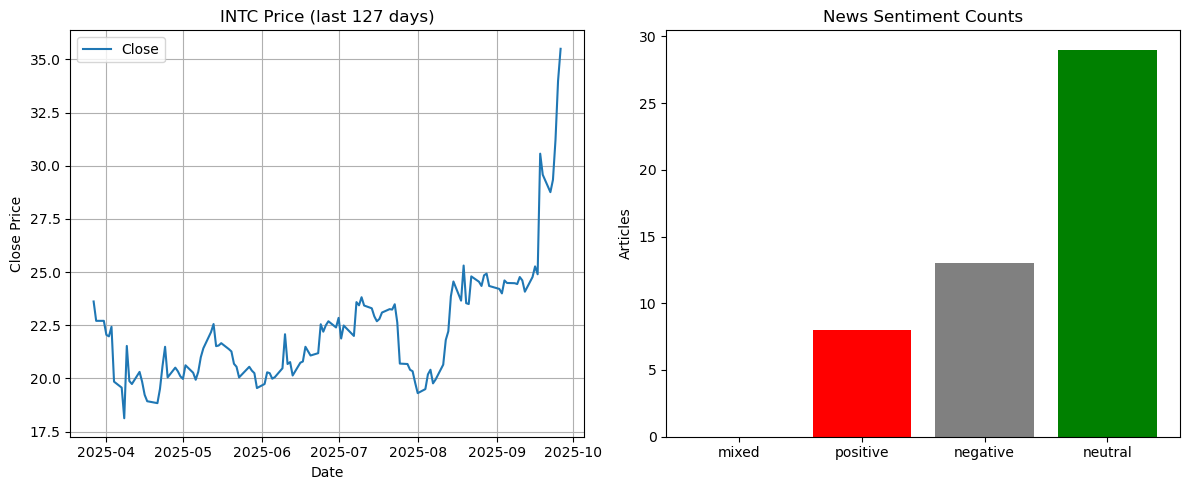

In [15]:
## Step 14 — Visualization

def visualize_results(results: dict):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Price chart (Yahoo Finance) ---
    yf_part = results.get("yahoo_finance", {})
    ticker = results.get("ticker", "TICKER")
    if "rows" in yf_part and yf_part.get("rows", 0) > 0:
        # Rerun adapter to get full price series
        prices = orch.yahoo.adapter.fetch_prices(ticker, period="6mo", interval="1d")
        axes[0].plot(prices["Date"], prices["Close"], label="Close")
        axes[0].set_title(f"{ticker} Price (last {len(prices)} days)")
        axes[0].set_xlabel("Date")
        axes[0].set_ylabel("Close Price")
        axes[0].legend()
        axes[0].grid(True)
    else:
        axes[0].text(0.5, 0.5, "No price data", ha="center", va="center")
        axes[0].set_axis_off()

    # --- News sentiment bar chart ---
    news_counts = results.get("news", {}).get("counts", {})
    if news_counts:
        labels = list(news_counts.keys())
        values = [news_counts[k] for k in labels]
        axes[1].bar(labels, values, color=["green","red","gray"])
        axes[1].set_title("News Sentiment Counts")
        axes[1].set_ylabel("Articles")
    else:
        axes[1].text(0.5, 0.5, "No news data", ha="center", va="center")
        axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()

# Example visualization for the last run
visualize_results(res)